# Bearing capacity of pile groups with Python

Usually, in common engineering practice, there is the abit to desing the lenght of piles in group taking into considerations the most loaded pile. In most of the cases there is a back and forth between the geotech and structural engineer where first the firs give to the second piles springs and bearing capacity, and the second extract the highest load on pile as the dimensioning one.
Recently Marco stepped  into this <a href = "https://www.researchgate.net/publication/324128051_Bearing_capacity_of_pile_groups_under_vertical_eccentric_load"> article  </a> from Laora, de Sanctis and Aversa from  "Acta Geotecnica".
We found the contribution valuable and we though it could be interesting for professionals to develop a tools able to implement this formulation.
Reference shall be made to article for a detailed explanation of the therethical background involved, the underlying principle is that when in group the bearing capacity of piles is increased by the axial contribution in traction of piles on the opposite side of load directions.
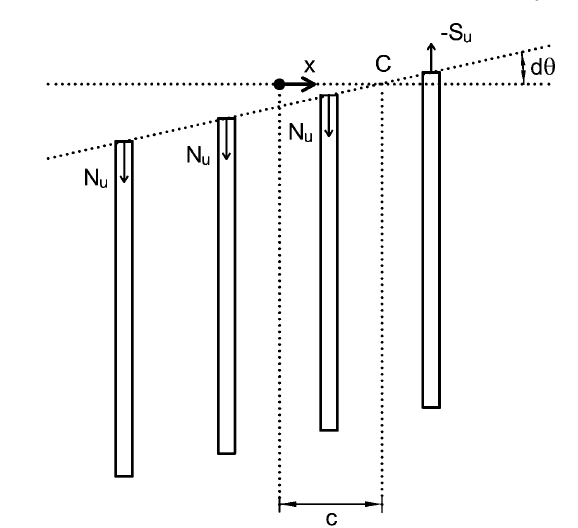

The final objective is to to create an interaction diagram able to provide a distance from failure for each load combinations.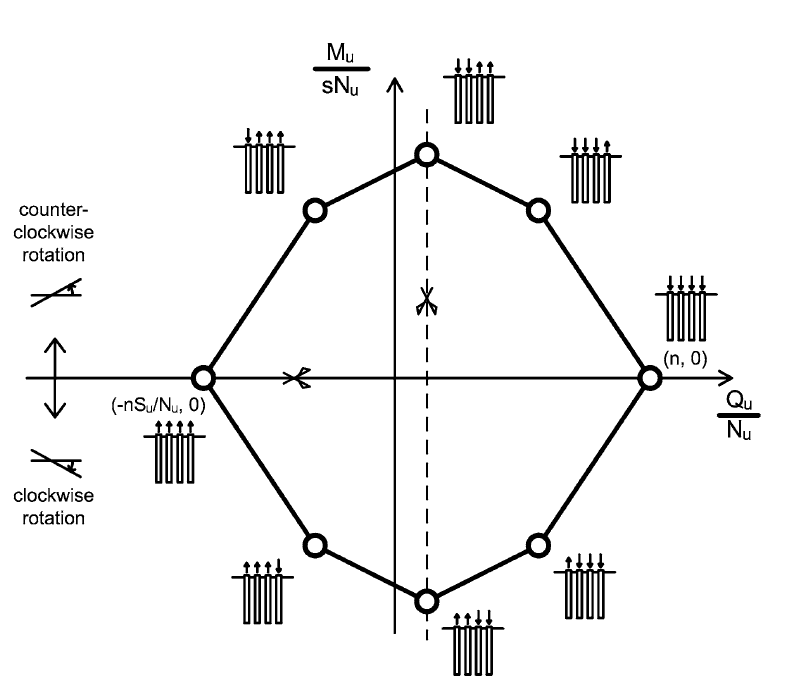